In [1]:
#Imported necessary libraries and functions
import numpy as np
import pandas as pd 
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
%matplotlib inline

In [2]:
#Read all data into dataframes and SQL connection
cast = sqlite3.connect('zippedData/im.db')
df_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
df_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep='\t')
df_reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding = 'windows-1252')
df_popular = pd.read_csv("zippedData/tmdb.movies.csv.gz")
df_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

In [3]:
#Converted all movie titles to strings, since some movies were read as integers
df_budget['movie'] = df_budget['movie'].astype(str)

#Removed all special characters from titles and made them all lower case to increase chances of matching other similar values in other databases
spec_char = r'[^\w\s]'
df_budget['movie'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_budget['movie'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_budget['movie'] = df_budget['movie'].str.lower()

#Converted release dates to datetime
df_budget['release_date']= pd.to_datetime(df_budget['release_date'])

#Cleaned budget, domestic gross, and worlwide gross columns to integers
df_budget['production_budget'] = df_budget['production_budget'].str.replace(',', '')
df_budget['production_budget'] = df_budget['production_budget'].str.replace('$', '')
df_budget['production_budget'] = df_budget['production_budget'].astype(int)
df_budget['domestic_gross'] = df_budget['domestic_gross'].str.replace(',', '')
df_budget['domestic_gross'] = df_budget['domestic_gross'].str.replace('$', '')
df_budget['domestic_gross'] = df_budget['domestic_gross'].astype(int)
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace(',', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace('$', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].astype(np.int64)

df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,avatar,425000000,760507625,2776345279
1,2,2011-05-20,piratesofthecaribbeanonstrangertides,410600000,241063875,1045663875
2,3,2019-06-07,darkphoenix,350000000,42762350,149762350
3,4,2015-05-01,avengersageofultron,330600000,459005868,1403013963
4,5,2017-12-15,starwarsepviiithelastjedi,317000000,620181382,1316721747


In [4]:
#Added profit columns
df_budget['worldwide_profit'] = df_budget['worldwide_gross'] - df_budget['production_budget']
df_budget['domestic_profit'] = df_budget['domestic_gross'] - df_budget['production_budget']

#Sorted data by highest overall profits worlwide
df_budget.sort_values(by = ['worldwide_profit'], ascending = False, inplace = True)

#Description of numerical data without scientific notation and rounding to the 2nd decimal place
df_budget.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
count,5782.00,5782.00,5782.00,5782.00,5782.00,5782.00
mean,50.37,31587757.10,41873326.87,91487460.91,59899703.81,10285569.77
std,28.82,41812076.83,68240597.36,174719968.78,146088881.08,49921366.46
min,1.00,1100.00,0.00,0.00,-200237650.00,-307237650.00
25%,25.00,5000000.00,1429534.50,4125414.75,-2189070.75,-9132757.00
50%,50.00,17000000.00,17225945.00,27984448.50,8550285.50,-348775.50
75%,75.00,40000000.00,52348661.50,97645836.50,60968501.75,17781444.00
max,100.00,425000000.00,936662225.00,2776345279.00,2351345279.00,630662225.00


In [5]:
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2351345279,335507625
42,43,1997-12-19,titanic,200000000,659363944,2208208395,2008208395,459363944
6,7,2018-04-27,avengersinfinitywar,300000000,678815482,2048134200,1748134200,378815482
5,6,2015-12-18,starwarsepviitheforceawakens,306000000,936662225,2053311220,1747311220,630662225
33,34,2015-06-12,jurassicworld,215000000,652270625,1648854864,1433854864,437270625


In [6]:
%%bash 

sqlite3 zippedData/im.db
.tables

directors      movie_akas     movie_ratings  principals   
known_for      movie_basics   persons        writers      


In [7]:
#Created a query that extracted the necessary information from the im.db file
review_query = """
    SELECT movie_basics.primary_title AS title, movie_basics.genres AS genres, 
    movie_ratings.averagerating AS average_rating, movie_ratings.numvotes AS num_votes, movie_akas.region AS region
    FROM movie_basics
    JOIN movie_ratings
        ON movie_basics.movie_id = movie_ratings.movie_id
    JOIN movie_akas
        ON movie_basics.movie_id = movie_akas.movie_id
    WHERE region = 'US'
    ORDER BY movie_ratings.averagerating DESC
"""
#Removed WHERE language = 'en' because there is an enormous amount of missing data

#Converted SQL query to Pandas Dataframe
df_reviews = pd.read_sql(review_query, cast)

#Removed all special characters from titles and made them all lower case to increase chances of matching other similar values in other databases
df_reviews['title'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_reviews['title'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_reviews['title'] = df_reviews['title'].str.lower()

#Replaced NaNs in genres column with a placeholder string so it can be iterable when converted to a dictionary
df_reviews['genres'] = df_reviews['genres'].fillna('Unknown')
df_reviews.drop_duplicates(subset = 'title', keep = 'first', inplace = True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25785 entries, 0 to 30193
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           25785 non-null  object 
 1   genres          25785 non-null  object 
 2   average_rating  25785 non-null  float64
 3   num_votes       25785 non-null  int64  
 4   region          25785 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In [8]:
#Created dictionary with movie titles as keys and list of genres as values
genres = pd.Series(df_reviews.genres.values, index = df_reviews.title).to_dict()
delimiter = ','
for key, value in genres.items():
    genres[key] = value.split(delimiter)
genres

{'freeingberniebaran': ['Crime', 'Documentary'],
 'revolutionfood': ['Documentary'],
 'dogdaysintheheartland': ['Drama'],
 'allaroundus': ['Documentary'],
 'ellisislandthemakingofamasterraceinamerica': ['Documentary', 'History'],
 'flyhighstoryofthediscdog': ['Documentary'],
 'adedicatedlifephoebebrandbeyondthegroup': ['Documentary'],
 'sendmymailtonashville': ['Biography', 'Documentary', 'Music'],
 'hirostable': ['Documentary'],
 'risethestoryofaugustines': ['Documentary', 'Music'],
 'ourfriendjon': ['Documentary'],
 'hizam': ['Documentary'],
 'freieräume': ['Documentary'],
 'silverwingsflyingdreamsthecompletestoryofthewomenairforceservicepilots': ['Biography',
  'Documentary',
  'Drama'],
 'onceuponatimeinhollywood': ['Comedy', 'Drama'],
 'manryatseainthewakeofadream': ['Documentary'],
 'blackbear': ['Drama', 'Sport'],
 'trenchesofrock': ['Documentary', 'Drama', 'Music'],
 '50yearsofthe911': ['Documentary'],
 '7thgeneration': ['Documentary'],
 'onthinice': ['Documentary', 'Drama', 'S

In [9]:
#Created a list of genre values
list_of_genres = []
for key, value in genres.items():
    for index in value:
        if index not in list_of_genres:
            list_of_genres.append(index)
list_of_genres

['Crime',
 'Documentary',
 'Drama',
 'History',
 'Biography',
 'Music',
 'Comedy',
 'Sport',
 'Animation',
 'Family',
 'War',
 'Action',
 'News',
 'Fantasy',
 'Adventure',
 'Western',
 'Musical',
 'Romance',
 'Unknown',
 'Mystery',
 'Sci-Fi',
 'Game-Show',
 'Horror',
 'Thriller',
 'Reality-TV',
 'Adult']

In [10]:
#Counted the number of films in each genre
genre_count = {}
for genre in list_of_genres:
    genre_count[genre] = 0
for key, value in genres.items():
    for index in value:
        genre_count[index] += 1
genre_count

{'Crime': 1920,
 'Documentary': 6434,
 'Drama': 9871,
 'History': 1090,
 'Biography': 1616,
 'Music': 818,
 'Comedy': 6230,
 'Sport': 507,
 'Animation': 611,
 'Family': 1283,
 'War': 255,
 'Action': 2889,
 'News': 317,
 'Fantasy': 890,
 'Adventure': 1768,
 'Western': 169,
 'Musical': 229,
 'Romance': 2070,
 'Unknown': 124,
 'Mystery': 1258,
 'Sci-Fi': 1183,
 'Game-Show': 2,
 'Horror': 4070,
 'Thriller': 3575,
 'Reality-TV': 7,
 'Adult': 2}

In [11]:
# Perform inner join on 'B' column in df1 and 'D' column in df2
result = pd.merge(df_budget, df_reviews, how='inner', left_on='movie', right_on='title')

# Extract the values that are in both columns
common_values = result['movie'].tolist()
movie_titles = list(set(common_values))
print(len(movie_titles))

1778


In [12]:
#Created a new dataframe that had combined, cleaned, and index-aligned data on worldwide/domestic profit, average rating, release date, genres, and number of votes
worldwide_profit = []
ww = 0
domestic_profit = []
dom = 0
average_rating = []
rat = 0.0
release_date = []
rel = None
movie_genres = []
gen = None
vote_count = []
vote = None

for title in movie_titles:
    ww = df_budget.loc[df_budget['movie'] == title, 'worldwide_profit'].iloc[0]
    worldwide_profit.append(ww)
    dom = df_budget.loc[df_budget['movie'] == title, 'domestic_profit'].iloc[0]
    domestic_profit.append(dom)
    rat = df_reviews.loc[df_reviews['title'] == title, 'average_rating'].iloc[0]
    average_rating.append(rat)
    rel = df_budget.loc[df_budget['movie'] == title, 'release_date'].iloc[0].date()
    release_date.append(rel)
    gen = df_reviews.loc[df_reviews['title'] == title, 'genres'].iloc[0]
    movie_genres.append(gen)
    vote = df_reviews.loc[df_reviews['title'] == title, 'num_votes'].iloc[0]
    vote_count.append(vote)

d = {'title': movie_titles, 'release_date': release_date, 'movie_genres': movie_genres, 'worldwide_profit': worldwide_profit, 'domestic_profit': domestic_profit, 'average_rating': average_rating, 'num_votes': vote_count}
df = pd.DataFrame(data = d)
df['movie_genres'] = df['movie_genres'].map(lambda x: x.split(','))

In [13]:
df.head()

,title,release_date,movie_genres,worldwide_profit,domestic_profit,average_rating,num_votes
0,thelastfiveyears,2015-02-13,"[Comedy, Drama, Musical]",-1794702,-1852701,5.9,8735
1,thefavourite,2018-11-23,"[Biography, Drama, History]",79113929,19366783,7.6,116011
2,krampus,2015-12-04,"[Comedy, Fantasy, Horror]",46788393,27725475,6.2,55400
3,oneforthemoney,2012-01-27,"[Action, Comedy, Crime]",-5802779,-15585473,5.3,38473
4,lifeoftheparty,2018-05-11,[Comedy],35759911,23059911,5.5,25756


In [14]:
#Ordered by worldwide profit
df_ww = df.sort_values(by = 'worldwide_profit', ascending = False)
df_ww.head(10)

,title,release_date,movie_genres,worldwide_profit,domestic_profit,average_rating,num_votes
1055,avengersinfinitywar,2018-04-27,"[Action, Adventure, Sci-Fi]",1748134200,378815482,8.5,670926
351,jurassicworld,2015-06-12,"[Action, Adventure, Sci-Fi]",1433854864,437270625,7.0,539338
1422,furious7,2015-04-03,"[Action, Crime, Thriller]",1328722794,163007020,7.2,335074
885,theavengers,2012-05-04,"[Action, Adventure, Sci-Fi]",1292935897,398279547,8.1,1183655
787,blackpanther,2018-02-16,"[Action, Adventure, Sci-Fi]",1148258224,500059566,7.3,516148
725,jurassicworldfallenkingdom,2018-06-22,"[Action, Adventure, Sci-Fi]",1135772799,247719760,6.2,219125
287,frozen,2013-11-22,"[Adventure, Animation, Comedy]",1122469910,250738009,7.5,516998
968,beautyandthebeast,2017-03-17,"[Family, Fantasy, Musical]",1099199706,344014165,7.2,238325
1396,minions,2015-07-10,"[Adventure, Animation, Comedy]",1086336173,262045770,6.4,193917
1208,avengersageofultron,2015-05-01,"[Action, Adventure, Sci-Fi]",1072413963,128405868,7.3,665594


In [15]:
#Ordered by Domestic Profit
df_dom = df.sort_values(by = 'domestic_profit', ascending = False)
df_dom.head(10)

,title,release_date,movie_genres,worldwide_profit,domestic_profit,average_rating,num_votes
787,blackpanther,2018-02-16,"[Action, Adventure, Sci-Fi]",1148258224,500059566,7.3,516148
351,jurassicworld,2015-06-12,"[Action, Adventure, Sci-Fi]",1433854864,437270625,7.0,539338
355,incredibles2,2018-06-15,"[Action, Adventure, Animation]",1042520711,408581744,7.7,203510
885,theavengers,2012-05-04,"[Action, Adventure, Sci-Fi]",1292935897,398279547,8.1,1183655
1055,avengersinfinitywar,2018-04-27,"[Action, Adventure, Sci-Fi]",1748134200,378815482,8.5,670926
968,beautyandthebeast,2017-03-17,"[Family, Fantasy, Musical]",1099199706,344014165,7.2,238325
1651,rogueoneastarwarsstory,2016-12-16,"[Action, Adventure, Sci-Fi]",849102856,332177324,7.8,478592
1605,thehungergames,2012-03-23,"[Action, Adventure, Sci-Fi]",597923379,328010692,7.2,795227
52,jumanjiwelcometothejungle,2017-12-20,"[Action, Adventure, Comedy]",874496193,314508916,7.0,242735
1586,deadpool,2016-02-12,"[Action, Adventure, Comedy]",743025593,305070709,8.0,820847


In [16]:
#Ordered by rating
df_rat = df.sort_values(by = 'average_rating', ascending = False)
df_rat = df_rat.loc[df_rat['num_votes'] >= 5]
df_rat.head(10)

,title,release_date,movie_genres,worldwide_profit,domestic_profit,average_rating,num_votes
1674,thewall,2017-05-12,[Documentary],1495262,-1196936,9.2,8
279,5050,2011-09-30,[Documentary],33334735,27016118,9.0,10
443,dragonfly,2002-02-22,"[Action, Adventure, Sci-Fi]",-29936195,-29936195,9.0,5
1020,frankenstein,1994-11-04,[Drama],67006296,-22993704,9.0,1832
1487,darkblue,2003-02-21,"[Crime, Drama]",-2737935,-5762530,8.9,9
538,teeth,2008-01-18,[Drama],350641,-1652422,8.8,25
356,messageinabottle,1999-02-12,[Adventure],22880016,22880016,8.8,30
620,skintrade,2015-05-08,[Documentary],-8998758,-8998758,8.8,31
1206,stuck,2008-05-30,"[Comedy, Drama]",-4932495,-4932495,8.8,5
507,inception,2010-07-16,"[Action, Adventure, Sci-Fi]",675524642,132576195,8.8,1841066


In [17]:
#Calculated the total average profit gained by each genre
genre_ww_profits = {}
genre_dom_profits = {}
for genre in list_of_genres:
    total_worldwide_profit = 0
    n_ww = 0
    total_domestic_profit = 0
    n_dom = 0
    for i in range(len(df['title'])):
        if genre in df['movie_genres'][i]:
            total_worldwide_profit += df['worldwide_profit'][i]
            total_domestic_profit += df['domestic_profit'][i]
            n_ww += 1
            n_dom += 1
    if total_worldwide_profit > 0:
        genre_ww_profit = round((total_worldwide_profit / n_ww), 2)
        genre_dom_profit = round((total_domestic_profit / n_dom), 2)
        genre_ww_profits[genre] = genre_ww_profit
        genre_dom_profits[genre] = genre_dom_profit

genre_dom_profits

{'Crime': 5097254.03,
 'Documentary': 2522218.62,
 'Drama': 7556410.57,
 'History': 5757369.3,
 'Biography': 13695214.24,
 'Music': 16934310.08,
 'Comedy': 17156008.06,
 'Sport': 6777459.26,
 'Animation': 35596650.23,
 'Family': 15368716.39,
 'War': -4937880.72,
 'Action': 10491515.84,
 'News': -13356506.0,
 'Fantasy': 1908758.76,
 'Adventure': 20472201.45,
 'Western': -12214318.2,
 'Musical': 25605769.92,
 'Romance': 10945200.02,
 'Unknown': 909808.0,
 'Mystery': 12801354.98,
 'Sci-Fi': 25369301.32,
 'Horror': 12610824.19,
 'Thriller': 10256414.1}

In [18]:
#Explode the list of genres in the movie_genres column so they can be grouped
df_exploded = df.explode('movie_genres')

#Group by genre and return the mean profits, ratings, and number of ratings
df_genre = df_exploded.groupby('movie_genres').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_genre.drop('Unknown', axis = 'rows', inplace = True)
df_genre.reset_index(inplace = True)

#Convert numerical values back into floats
df_genre['worldwide_profit'] = df_genre['worldwide_profit'].astype(float)
df_genre['domestic_profit'] = df_genre['domestic_profit'].astype(float)
df_genre['average_rating'] = df_genre['average_rating'].astype(float)
df_genre['num_votes'] = df_genre['num_votes'].astype(float)
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_genres      22 non-null     object 
 1   worldwide_profit  22 non-null     float64
 2   domestic_profit   22 non-null     float64
 3   average_rating    22 non-null     float64
 4   num_votes         22 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1008.0+ bytes


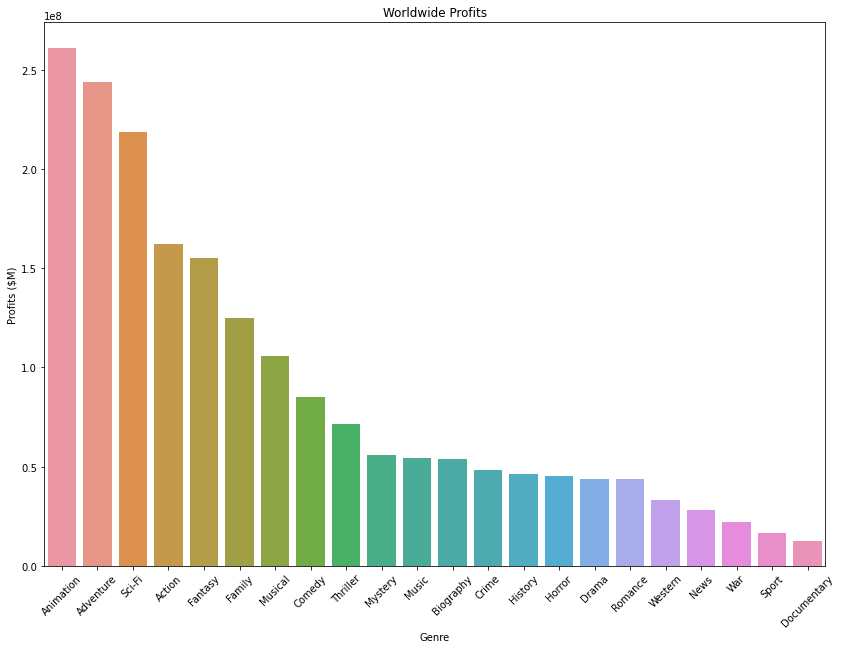

In [19]:
df_genre.sort_values(by = 'worldwide_profit', ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (14,10))
sns.barplot(x = 'movie_genres', y = 'worldwide_profit', data = df_genre)
ax.set_title('Worldwide Profits')

ax.set_xlabel('Genre')
ax.set_ylabel('Profits ($M)')
plt.xticks(rotation=45);


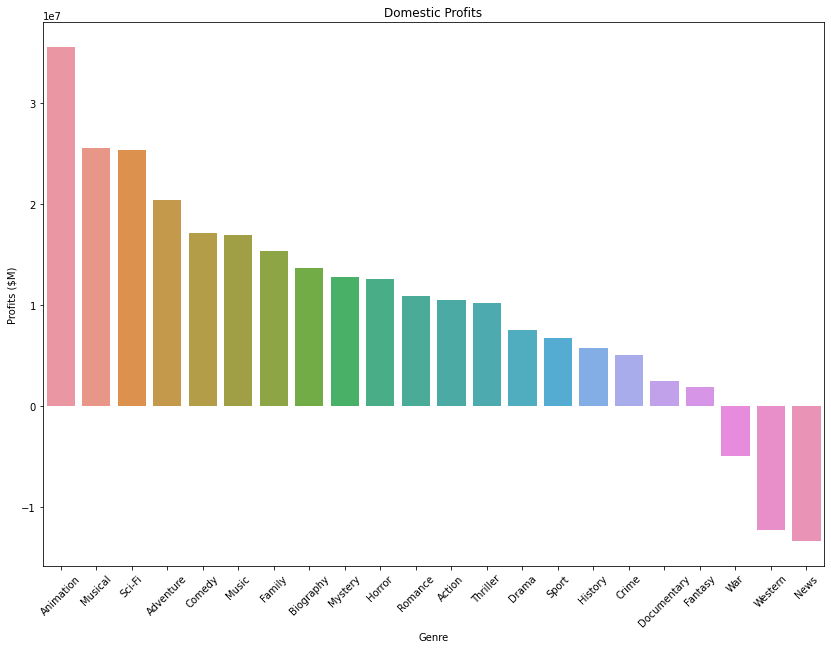

In [20]:
df_genre.sort_values(by = 'domestic_profit', ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (14,10))
sns.barplot(x = 'movie_genres', y = 'domestic_profit', data = df_genre)
ax.set_title('Domestic Profits')

ax.set_xlabel('Genre')
ax.set_ylabel('Profits ($M)')
plt.xticks(rotation=45);
